#Automatización de Fichas 2.1 y 2.2
© 2025. Developed by Eduard Peñas Balart.UPC (ESEIAAT). 7 EXPERTS

Este programa genera fichas de ampliacion 2.1 y 2.2 en Word de forma automática a partir de archivos de Excel:   

- **`2.1 (Personal)`** se crea a partir de un único archivo Excel con datos de personas.  
- **`2.2 (Entidades y Facturas)`** se genera combinando dos archivos Excel: uno con información de empresas y otro con sus facturas.




##0. Instalación de Dependencias
Para que Google Colab pueda generar las fichas, debe ejecutar esta celda. Si aparece un aviso para sincronizar con Drive, acéptelo para acceder a los archivos. 🚀

In [ ]:
# @title Pulsa ▶️ {"display-mode":"form"}
!pip install pandas python-docx
# 📌 Importaciones necesarias
import pandas as pd
from docx import Document
from docx.shared import Cm, Pt, RGBColor
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.oxml import OxmlElement, ns
from docx.oxml.ns import qn
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Copiar el archivo desde tu Drive a Colab
!cp "/content/drive/My Drive/2.1.docx" "/tmp/"
!cp "/content/drive/My Drive/2.2.docx" "/tmp/"
!cp "/content/drive/My Drive/archivo.png" "/tmp/"
!cp "/content/drive/My Drive/Captura1.png" "/tmp/"
!cp "/content/drive/My Drive/Captura2.png" "/tmp/"
!cp "/content/drive/My Drive/Excel_Colaboraciones_2.2.xlsx" "/tmp/"
!cp "/content/drive/My Drive/Excel_Facturas_2.2.xlsx" "/tmp/"
!cp "/content/drive/My Drive/Excel_Personal_2.1.xlsx" "/tmp/"



print("✅ Archivo copiado correctamente en Colab.")
# 📌 Funciones utilitarias

def cm_to_pt(cm):
    """Convierte centímetros a puntos"""
    return cm * 28.3465

def set_cell_color(cell, color_hex):
    """Aplica un color de fondo a una celda en formato hexadecimal."""
    cell_properties = cell._tc.get_or_add_tcPr()
    shading = OxmlElement("w:shd")
    shading.set(qn("w:val"), "clear")
    shading.set(qn("w:fill"), color_hex)
    cell_properties.append(shading)

def set_text_format(cell, bold=False):
    """Aplica formato Arial 10 y negrita opcionalmente a una celda con alineación a la izquierda."""
    if not cell.paragraphs:
        cell.add_paragraph()
    for paragraph in cell.paragraphs:
        for run in paragraph.runs:
            run.font.name = "Arial"
            run.font.size = Pt(10)
            run.bold = bold
        paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT

def add_text_to_cell(cell, text, bold=False):
    """Añade texto con formato a una celda sin perder estilos."""
    cell.text = ""
    paragraph = cell.paragraphs[0]
    run = paragraph.add_run(text)
    run.font.name = "Arial"
    run.font.size = Pt(10)
    run.bold = bold
    paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT

def get_value_or_default(df, index, column_name, default="❏"):
    """Obtiene el valor de una celda del DataFrame o un valor por defecto si está vacío."""
    value = df.iloc[index].get(column_name, default)
    if pd.isna(value):
        return default
    return value

def create_titled_box(doc, title_text, height=150, width=400):
    """Crea un recuadro con un título"""
    title = doc.add_paragraph()
    run = title.add_run(title_text)
    run.font.name = "Arial"
    run.font.size = Pt(10)
    run.bold = True
    run.font.color.rgb = RGBColor(0, 0, 0)
    title.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY
    # Aplicar sangrías izquierda y derecha
    title.paragraph_format.left_indent = Cm(-1)    # Sangría izquierda de -1 cm
    title.paragraph_format.right_indent = Cm(-0.75)  # Sangría derecha de -0.75 cm

    # Aplicar interlineado sencillo
    title.paragraph_format.line_spacing = 1.0

    # No agregar espacio entre párrafos
    title.paragraph_format.space_before = Pt(0)
    title.paragraph_format.space_after = Pt(0)
    table = doc.add_table(rows=1, cols=1)
    table.style = 'Table Grid'

    cell = table.cell(0, 0)
    table.autofit = False

    table.rows[0].height = Pt(height)
    table.columns[0].width = Pt(width)
    # 📌 Acceder al XML de la tabla
    tbl = table._element  # Obtener el XML de la tabla
    tblPr = tbl.find(ns.qn('w:tblPr'))  # Buscar propiedades de la tabla
    if tblPr is None:
        tblPr = OxmlElement('w:tblPr')
        tbl.insert(0, tblPr)  # Insertar en la primera posición

    # 📌 Alinear la tabla a la izquierda
    jc = OxmlElement('w:jc')
    jc.set(ns.qn('w:val'), 'left')  # Alinear a la izquierda
    tblPr.append(jc)

    # 📌 Aplicar sangría izquierda de -0.83 cm (Convertir cm a twips: 1 cm = 567 twips)
    tblInd = OxmlElement('w:tblInd')
    tblInd.set(ns.qn('w:w'), str(int(-0.83 * 567)))  # Convertir -0.83 cm a twips
    tblInd.set(ns.qn('w:type'), 'dxa')
    tblPr.append(tblInd)

    # 📌 Definir el ancho preferido de la tabla (18.33 cm en twips: 1 cm = 567 twips)
    tblW = OxmlElement('w:tblW')
    tblW.set(ns.qn('w:w'), str(int(18.33 * 567)))  # Convertir 18.33 cm a twips
    tblW.set(ns.qn('w:type'), 'dxa')  # Tipo de unidad
    tblPr.append(tblW)
    set_text_format(cell, bold=False)
    return table

def set_cell_format(cell, text, font_name="Arial", font_size=10, bold=True, bg_color="F2F2F2", hide_text=False):
    """Aplica formato a una celda: texto, fuente, tamaño, negrita y color de fondo"""

    # Limpiar la celda y agregar un párrafo nuevo
    cell.text = ""
    paragraph = cell.paragraphs[0] if cell.paragraphs else cell.add_paragraph()

    # Agregar el texto visible
    run = paragraph.add_run(text)
    run.font.name = font_name
    run.font.size = Pt(font_size)
    run.bold = bold
    cell.paragraphs[0].alignment = WD_PARAGRAPH_ALIGNMENT.LEFT  # Alinear a la izquierda

    # Aplicar color de fondo a la celda
    set_cell_color(cell, bg_color)

    # Si hay que ocultar texto, agregar "2" en el color del fondo
    if hide_text:
        run2 = paragraph.add_run("2")
        run2.font.name = font_name
        run2.font.size = Pt(font_size)
        run2.bold = bold
        run2.font.color.rgb = RGBColor(242, 242, 242)  # Mismo color de fondo para ocultarlo



def set_cell_background(cell, color_hex):
    """Aplica un color de fondo a una celda en formato hexadecimal."""
    cell_properties = cell._element.get_or_add_tcPr()
    shading = OxmlElement("w:shd")
    shading.set(qn("w:val"), "clear")
    shading.set(qn("w:fill"), color_hex)
    cell_properties.append(shading)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.5 MB/s eta 0:00:00
Mounted at /content/drive
✅ Archivo copiado correctamente en Colab.




## 1. Descarga las plantillas de excel para generar las fichas (OPCIONAL)
El enlace abre el archivo en drive. Para descargarlo:

Archivo->Descargar (En formato .xlsx )
- [📄 Descargar Plantilla Excel (2.1)](https://docs.google.com/spreadsheets/d/175CNZL_6v5UxH9xYUizNBMNPR1afxfzD/edit?usp=drive_link&ouid=117407540439291709740&rtpof=true&sd=true)
- [📄 Descargar Plantilla Excel Colaboraciones (2.2)](https://docs.google.com/spreadsheets/d/1QCM5DzPY5LSHN5JibdIWPMZzzNBKk8SC/edit?usp=drive_link&ouid=117407540439291709740&rtpof=true&sd=true)
- [📄 Descargar Plantilla Excel Facturas(2.2)](https://docs.google.com/spreadsheets/d/1i6IoxomSAZaFmOoQJwkDtDidEl8aRysf/edit?usp=sharing&ouid=117407540439291709740&rtpof=true&sd=true)


## 2.Rellena el Excel

####📌 En el archivo Excel_Personal_2.1, cada fila representa una ***persona***
| Nombre  | Apellidos | Puesto      | Departamento | Horas trabajadas | Coste por hora (€) |
|---------|----------|------------|-------------|-----------------|----------------|
| Juan    | Pérez    | Ingeniero  | I+D         | 40              | 25             |
| María   | López    | Analista   | Finanzas    | 35              | 30             |
| Carlos  | Fernández | Gerente   | Ventas      | 30              | 40             |
| Laura   | Gómez    | Diseñadora | Marketing   | 45              | 28             |


####📌 En el archivo Excel_Colaboraciones_2.2, cada fila representa una ***empresa***.
| Razón social  | País de la entidad | Entidad contratante | NIF     | Localidad | Provincia | País de realización |
|--------------|----------------|------------------|--------|----------|-----------|------------------|
| Empresa A   | España         | Cliente X       | A1234567 | Madrid   | Madrid    | España          |
| Empresa B   | Francia        | Cliente Y       | B7654321 | París    | Isla de Francia | Francia |


####📌 En el archivo Excel_Facturas_2.2, cada fila representa una ***factura***.

Para que el programa pueda asociar correctamente las a una empresa, el nombre de la entidad debe escribirse exactamente igual que en la columna "Razón social" del archivo Excel_Colaboraciones_2.2.

|  **Columna**        | ✍ **Qué debes escribir** |
|-----------------|-----------------------------------|
| **Entidad** | Nombre de la empresa (debe coincidir con "Razón social" en `Excel_Colaboraciones_2.2`). |
| **Nombre factura** | Un nombre o referencia para la factura. |
| **Importe (€)** | El valor total de la factura en euros (sin símbolos). |


### ✅ **Ejemplo de cómo rellenarlo correctamente**  

| Entidad    | Nombre factura | Importe (€) |
|-----------|---------------|------------|
| Empresa A | Factura 1     | 1000       |
| Empresa A | Factura 2     | 2000       |
| Empresa B | Factura 1     | 1800       |
| Empresa C | Factura 1     | 1300       |

## 3. Sube tus archivos a Google Colab
Para subir un archivo a Google Colab, haz clic en el icono de carpeta en el lado izquierdo, luego en el botón "Subir al almacenamiento de la sesión", selecciona el archivo desde tu explorador de archivos y espera a que aparezca en la lista.



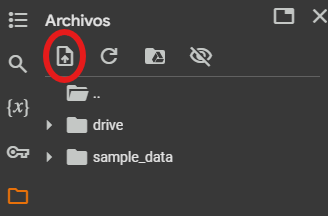

In [ ]:
# @title Aquí lo puede ver: {"display-mode":"form"}
from IPython.display import display
from PIL import Image

# Ruta de la imagen en Colab
image_path = "/tmp/archivo.png"  # Cambia esto con la ruta de tu imagen

# Cargar y mostrar la imagen
img = Image.open(image_path)
display(img)



* Para la 2.1 el Excel el archivo que sube tiene que llamarse:
"Excel_Personal_2.1.xlsx"

* Para la 2.2 el Excel de Colaboraciones el archivo que sube tiene que llamarse:
"Excel_Colaboraciones_2.2.xlsx"

* Para la 2.2 el Excel de facturas del archivo tiene que sube llamarse:
"Excel_Facturas_2.2.xlsx"

Para cambiar el nombre de un archivo en Colab, haga clic en los tres puntos junto al archivo y selecciona la opción "Cambiar nombre".



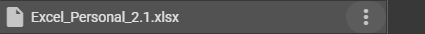

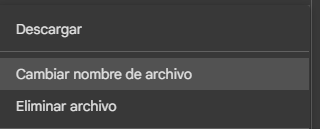

In [ ]:
# @title Aqui lo puedes ver: {"vertical-output":true,"display-mode":"form"}
from IPython.display import display
from PIL import Image

# Ruta de la imagen en Colab
image_path = "/tmp/Captura1.png"  # Cambia esto con la ruta de tu imagen
image_path2 = "/tmp/Captura2.png"  # Cambia esto con la ruta de tu imagen

# Cargar y mostrar la imagen
img = Image.open(image_path)
img2 = Image.open(image_path2)
display(img2)
display(img)


# 📄 **Generación de la Ficha 2.1 de Ampliación**




In [ ]:
# @title 2.1 Procure que el documento que sube se llame "Excel_Personal_2.1.xlsx" {"vertical-output":true,"display-mode":"form"}

# Cargar los archivos Excel
file_ficha = "/content/Excel_Personal_2.1.xlsx"
df_ficha = pd.read_excel(file_ficha)

# Ruta del documento de salida
output_file = "/tmp/Ficha_Ampliacion_Aptdo_2_1.docx"

# Crear un único documento Word
doc_master = Document()

for index in range(len(df_ficha)):

    # **TABLA 1: IDENTIFICACIÓN DE PERSONAL PARTICIPANTE DE ENTIDAD SOLICITANTE**
    title1 = doc_master.add_paragraph()
    run = title1.add_run("1. IDENTIFICACIÓN DE PERSONAL PARTICIPANTE DE ENTIDAD SOLICITANTE:")
    run.font.name = "Arial"
    run.font.size = Pt(10)
    run.bold = True
    run.font.color.rgb = RGBColor(0, 0, 0)
    title1.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY

    # Aplicar sangrías izquierda y derecha
    title1.paragraph_format.left_indent = Cm(-1)    # Sangría izquierda de -1 cm
    title1.paragraph_format.right_indent = Cm(-0.75)  # Sangría derecha de -0.75 cm

    # Aplicar interlineado sencillo
    title1.paragraph_format.line_spacing = 1.0

    # No agregar espacio entre párrafos
    title1.paragraph_format.space_before = Pt(0)
    title1.paragraph_format.space_after = Pt(0)
    # Crear tabla con 8 filas y 4 columnas
    table1 = doc_master.add_table(rows=8, cols=4)
    table1.style = 'Table Grid'
    # Ajustar la altura de las celdas a 0.5 cm
    for row in table1.rows:
        for cell in row.cells:
            cell.height = Cm(0.5)
    # 📌 Acceder al XML de la tabla
    tbl = table1._element  # Obtener el XML de la tabla
    tblPr = tbl.find(ns.qn('w:tblPr'))  # Buscar propiedades de la tabla
    if tblPr is None:
        tblPr = OxmlElement('w:tblPr')
        tbl.insert(0, tblPr)  # Insertar en la primera posición

    # 📌 Alinear la tabla a la izquierda
    jc = OxmlElement('w:jc')
    jc.set(ns.qn('w:val'), 'left')  # Alinear a la izquierda
    tblPr.append(jc)

    # 📌 Aplicar sangría izquierda de -0.83 cm (Convertir cm a twips: 1 cm = 567 twips)
    tblInd = OxmlElement('w:tblInd')
    tblInd.set(ns.qn('w:w'), str(int(-0.83 * 567)))  # Convertir -0.83 cm a twips
    tblInd.set(ns.qn('w:type'), 'dxa')
    tblPr.append(tblInd)

    # 📌 Definir el ancho preferido de la tabla (18.33 cm en twips: 1 cm = 567 twips)
    tblW = OxmlElement('w:tblW')
    tblW.set(ns.qn('w:w'), str(int(18.33 * 567)))  # Convertir 18.33 cm a twips
    tblW.set(ns.qn('w:type'), 'dxa')  # Tipo de unidad
    tblPr.append(tblW)

    # 📌 Aplicar la altura de fila a 0.5 cm
    for row in table1.rows:
        row.height = Cm(0.5)  # Establecer altura de 0.5 cm para cada fila

    # 📌 Aplicar anchos a cada columna (debes definir `column_widths` en cm)
    column_widths = [Cm(4.32), Cm(6.5), Cm(3.25), Cm(4.5)]  # Ajusta los valores según lo necesites
    for row in table1.rows:
        for j, width in enumerate(column_widths):
            row.cells[j].width = width

    # Fusionar columnas 2, 3 y 4 en filas 1 y 2
    table1.rows[0].cells[1].merge(table1.rows[0].cells[2]).merge(table1.rows[0].cells[3])
    table1.rows[1].cells[1].merge(table1.rows[1].cells[2]).merge(table1.rows[1].cells[3])

    # Aplicar color y formato a la primera columna
    for row in table1.rows:
        set_cell_color(row.cells[0], "F2F2F2")
        set_text_format(row.cells[0], bold=True)

    # Aplicar color y formato a celdas específicas de la columna 3 (índice 2)
    celdas_columna_3 = [2, 3, 4, 5, 6, 7]
    for fila in celdas_columna_3:
        set_cell_color(table1.rows[fila].cells[2], "F2F2F2")
        set_text_format(table1.rows[fila].cells[2], bold=True)  # Asegurar que la negrita se aplica
    # Llenar la tabla con los datos de Excel
    fields1 = [
        ("Nombre", get_value_or_default(df_ficha, index, "Nombre"), "", ""),
    ("Apellidos", get_value_or_default(df_ficha, index, "Apellidos"), "", ""),
    ("Coste horario (€/hora)", f"{get_value_or_default(df_ficha, index, 'Coste horario (€/hora)', 0):.2f} €", "", ""),
    ("Coste total (€)", f"{get_value_or_default(df_ficha, index, 'Coste total (€)', 0):.2f} €",
        "Horas totales", int(get_value_or_default(df_ficha, index, "Horas totales", 0))),
    ("Coste I+D (€)", get_value_or_default(df_ficha, index, "Coste I+D (€)"),
        "Horas I+D", get_value_or_default(df_ficha, index, "Horas I+D")),
    ("Coste IT (€)", f"{get_value_or_default(df_ficha, index, 'Coste total (€)', 0):.2f} €",
        "Horas IT", int(get_value_or_default(df_ficha, index, "Horas totales", 0))),
    ("Departamento", get_value_or_default(df_ficha, index, "Departamento"),
        "Puesto actual", get_value_or_default(df_ficha, index, "Puesto actual")),
    ("Titulación 1", get_value_or_default(df_ficha, index, "Titulación 1"),
        "Titulación 2", get_value_or_default(df_ficha, index, "Titulación 2"))
    ]

    # Insertar datos con formato correcto
    for i, row_data in enumerate(fields1):
        row_cells = table1.rows[i].cells
        add_text_to_cell(row_cells[0], row_data[0], bold=True)  # Columna 1 en negrita

        if i < 2:
            add_text_to_cell(row_cells[1], row_data[1])
        else:
            if len(row_data) > 1:
                add_text_to_cell(row_cells[1], str(row_data[1]))
            if len(row_data) > 2:
                add_text_to_cell(row_cells[2], row_data[2], bold=(i in celdas_columna_3))  # Negrita en col 3
                add_text_to_cell(row_cells[3], str(row_data[3]))



    doc_master.add_paragraph()  # Agrega un párrafo vacío como espacio
    # **TABLA 2: IDENTIFICACIÓN DE PERSONAL PARTICIPANTE DE COLABORACIÓN EXTERNA**
    title2 = doc_master.add_paragraph()
    run = title2.add_run("2. IDENTIFICACIÓN DE PERSONAL PARTICIPANTE DE COLABORACIÓN EXTERNA:")
    run.font.name = "Arial"
    run.font.size = Pt(10)
    run.bold = True
    run.font.color.rgb = RGBColor(0, 0, 0)
    title2.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY

    # Aplicar sangrías izquierda y derecha
    title2.paragraph_format.left_indent = Cm(-1)    # Sangría izquierda de -1 cm
    title2.paragraph_format.right_indent = Cm(-0.75)  # Sangría derecha de -0.75 cm

    # Aplicar interlineado sencillo
    title2.paragraph_format.line_spacing = 1.0

    # No agregar espacio entre párrafos
    title2.paragraph_format.space_before = Pt(0)
    title2.paragraph_format.space_after = Pt(0)

    # Crear tabla con 8 filas y 5 columnas para la ficha de la colaboración externa
    table2 = doc_master.add_table(rows=8, cols=5)
    table2.style = 'Table Grid'
    # 📌 Acceder al XML de la tabla
    tbl = table2._element  # Obtener el XML de la tabla
    tblPr = tbl.find(ns.qn('w:tblPr'))  # Buscar propiedades de la tabla
    if tblPr is None:
        tblPr = OxmlElement('w:tblPr')
        tbl.insert(0, tblPr)  # Insertar en la primera posición

    # 📌 Alinear la tabla a la izquierda
    jc = OxmlElement('w:jc')
    jc.set(ns.qn('w:val'), 'left')  # Alinear a la izquierda
    tblPr.append(jc)

    # 📌 Aplicar sangría izquierda de -0.83 cm (Convertir cm a twips: 1 cm = 567 twips)
    tblInd = OxmlElement('w:tblInd')
    tblInd.set(ns.qn('w:w'), str(int(-0.83 * 567)))  # Convertir -0.83 cm a twips
    tblInd.set(ns.qn('w:type'), 'dxa')
    tblPr.append(tblInd)

    # 📌 Definir el ancho preferido de la tabla (18.33 cm en twips: 1 cm = 567 twips)
    tblW = OxmlElement('w:tblW')
    tblW.set(ns.qn('w:w'), str(int(18.33 * 567)))  # Convertir 18.33 cm a twips
    tblW.set(ns.qn('w:type'), 'dxa')  # Tipo de unidad
    tblPr.append(tblW)
    # 📌 Aplicar anchos a cada columna (debes definir `column_widths` en cm)
    column_widths = [Cm(4.32), Cm(4.75), Cm(4), Cm(1.76),Cm(2.23)]  # Ajusta los valores según lo necesites
    for row in table2.rows:
        for j, width in enumerate(column_widths):
            row.cells[j].width = width
    # Fusionar celdas según el formato
    table2.cell(0, 1).merge(table2.cell(0, 2))  # Fusionar columnas 2 y 3 en la primera fila
    table2.cell(1, 1).merge(table2.cell(1, 4))  # Fusionar columnas 2 a 5 en la segunda fila
    table2.cell(2, 1).merge(table2.cell(2, 4))  # Fusionar columnas 2 a 5 en la tercera fila
    table2.cell(3, 1).merge(table2.cell(3, 4))  # Fusionar columnas 2 a 5 en la cuarta fila

    # Fusionar columnas 4 y 5 en las filas 5, 6, 7 y 8
    table2.cell(4, 3).merge(table2.cell(4, 4))  # Quinta fila
    table2.cell(5, 3).merge(table2.cell(5, 4))  # Sexta fila
    table2.cell(6, 3).merge(table2.cell(6, 4))  # Séptima fila
    table2.cell(7, 3).merge(table2.cell(7, 4))  # Octava fila
     # Aplicar color y formato a la primera columna
    for row in table2.rows:
        set_cell_color(row.cells[0], "F2F2F2")
        set_text_format(row.cells[0], bold=True)
     # Aplicar color y formato a celdas específicas de la columna 3 (índice 2)
    celdas_columna_3 = [4, 5, 6, 7]
    for fila in celdas_columna_3:
        set_cell_color(table2.rows[fila].cells[2], "F2F2F2")
        set_text_format(table2.rows[fila].cells[2], bold=True)  # Asegurar que la negrita se aplica
    set_cell_color(table2.rows[0].cells[-2], "F2F2F2")
    # Encabezados de la tabla 2
    headers = [
        ("Entidad Colaboradora", "", "", "NIF", ""),
        ("Nombre", "", "", "", ""),
        ("Apellidos", "", "", "", ""),
        ("Perfil profesional", "", "", "", ""),
        ("Número de personas", "", "Coste horario (€/hora)", "", ""),
        ("Coste total (€)", "", "Horas totales", "", ""),
        ("Titulación 1", "", "Titulación 2", "", ""),
        ("Titulación 3", "", "Titulación 4", "", "")
    ]

    # Insertar los encabezados en la tabla 2 con formato
    for row_idx, header in enumerate(headers):
        for col_idx, text in enumerate(header):
            cell = table2.cell(row_idx, col_idx)
            if text:
                cell.text = text
                for paragraph in cell.paragraphs:
                    run = paragraph.runs[0]
                    run.font.name = "Arial"
                    run.font.size = Pt(10)
                    run.bold = True
                    run.font.color.rgb = RGBColor(0, 0, 0)

    # Mapeo de datos para la tabla 2
    cell_mapping2 = {
        "Entidad Colaboradora": (0, 1),
        "NIF": (0, 4),
        "Nombre": (1, 1),
        "Apellidos": (2, 1),
        "Perfil profesional": (3, 1),
        "Número de personas": (4, 1),
        "Coste horario (€/hora)": (4, 3),
        "Coste total (€)": (5, 1),
        "Horas totales": (5, 3),
        "Titulación 1": (6, 1),
        "Titulación 2": (6, 3),
        "Titulación 3": (7, 1),
        "Titulación 4": (7, 3)
    }
    doc_master.add_paragraph()  # Agrega un párrafo vacío como espacio
    create_titled_box(doc_master, "3. EXPERIENCIA PROFESIONAL RELACIONADA CON LA ACTIVIDAD DESARROLLADA EN EL PROYECTO: ",height=cm_to_pt(2.28), width=cm_to_pt(15.24))
    doc_master.add_paragraph()  # Agrega un párrafo vacío como espacio
    create_titled_box(doc_master, "4. FUNCIONES ASIGNADAS/DESARROLLADAS EN EL PROYECTO. ",height=cm_to_pt(2.28), width=cm_to_pt(15.24))

  # Insertar un salto de página después de cada conjunto de tablas
    if index < len(df_ficha) - 1:
      doc_master.add_page_break()

# Guardar el documento con todas las fichas combinadas
doc_master.save(output_file)

# Devolver la ruta del archivo generado
output_file
 # 📌 Cargar los documentos
documento_base = Document("/tmp/2.1.docx")  # Contiene el encabezado y las instrucciones
documento_fichas = Document(output_file)  # Contiene las fichas generadas

# 📌 Insertar el contenido de las fichas en el documento base
for element in documento_fichas.element.body:
    documento_base.element.body.append(element)

# 📌 Aplicar el estilo "Table Grid" a todas las tablas para que se vea el contorno
for table in documento_base.tables:
    table.style = "Table Grid"

# 📌 Guardar el documento final combinado
documento_base.save("Ficha_Ampliacion_Aptdo_2_1 01-01-2025 .docx")
nombre_archivo = "Ficha_Ampliacion_Aptdo_2_1 01-01-2025.docx"
# 📌 Mostrar mensaje al usuario
print(f"✅ El documento ha sido guardado con éxito.")
print(f"📂 Puedes encontrarlo en la carpeta de archivos de Google Colab con el nombre:")
print(f"➡ {nombre_archivo}")
print("\n📌 Si no ves el archivo, haz clic en el icono de la 📁 carpeta en la barra lateral izquierda.")

✅ El documento ha sido guardado con éxito.
📂 Puedes encontrarlo en la carpeta de archivos de Google Colab con el nombre:
➡ Ficha_Ampliacion_Aptdo_2_1 01-01-2025.docx

📌 Si no ves el archivo, haz clic en el icono de la 📁 carpeta en la barra lateral izquierda.


# 📄 **Generación de la Ficha 2.2 de Ampliación**





In [ ]:
# @title 2.2 Procure que los documentos que sube se llamen "Excel_Colaboraciones_2.2" y "Excel_Facturas_2.2" {"vertical-output":true,"display-mode":"form"}
# 📂 **Cargar datos desde el archivo Excel**
file_path = "Excel_Colaboraciones_2.2.xlsx"  # Asegúrate de que el archivo Excel está en la misma carpeta
df = pd.read_excel(file_path)

# Cargar datos de facturas desde el archivo Excel
facturas_file = "Excel_Facturas_2.2.xlsx"
df_facturas = pd.read_excel(facturas_file)

# Crear documento Word
doc = Document()

# Iterar sobre todas las entidades en el Excel
for i, row_data in df.iterrows():
    # Agregar título principal en cada iteración
    title = doc.add_paragraph()
    run = title.add_run("1. IDENTIFICACIÓN DE LA ENTIDAD COLABORADORA:")
    run.bold = True
    run.font.name = "Arial"
    run.font.size = Pt(10)
    title.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY

    # Aplicar sangrías izquierda y derecha
    title.paragraph_format.left_indent = Cm(-1)    # Sangría izquierda de -1 cm
    title.paragraph_format.right_indent = Cm(-0.75)  # Sangría derecha de -0.75 cm

    # Aplicar interlineado sencillo
    title.paragraph_format.line_spacing = 1.0

    # No agregar espacio entre párrafos
    title.paragraph_format.space_before = Pt(0)
    title.paragraph_format.space_after = Pt(0)
# Crear tabla con 6 filas y 5 columnas
    table = doc.add_table(rows=6, cols=5)
    table.style = "Table Grid"

    # Definir anchos personalizados para cada columna (en cm)
    column_widths = [Cm(4.07), Cm(3.65), Cm(7.1), Cm(1.14), Cm(2.37)]
    # 📌 Acceder al XML de la tabla
    tbl = table._element  # Obtener el XML de la tabla
    tblPr = tbl.find(ns.qn('w:tblPr'))  # Buscar propiedades de la tabla
    if tblPr is None:
        tblPr = OxmlElement('w:tblPr')
        tbl.insert(0, tblPr)  # Insertar en la primera posición

    # 📌 Alinear la tabla a la izquierda
    jc = OxmlElement('w:jc')
    jc.set(ns.qn('w:val'), 'left')  # Alinear a la izquierda
    tblPr.append(jc)

    # 📌 Aplicar sangría izquierda de -0.83 cm (Convertir cm a twips: 1 cm = 567 twips)
    tblInd = OxmlElement('w:tblInd')
    tblInd.set(ns.qn('w:w'), str(int(-0.83 * 567)))  # Convertir -0.83 cm a twips
    tblInd.set(ns.qn('w:type'), 'dxa')
    tblPr.append(tblInd)

    # 📌 Definir el ancho preferido de la tabla (18.33 cm en twips: 1 cm = 567 twips)
    tblW = OxmlElement('w:tblW')
    tblW.set(ns.qn('w:w'), str(int(18.33 * 567)))  # Convertir 18.33 cm a twips
    tblW.set(ns.qn('w:type'), 'dxa')  # Tipo de unidad
    tblPr.append(tblW)
    # Aplicar los anchos a cada columna
    for row in table.rows:
        for j, width in enumerate(column_widths):
            row.cells[j].width = width

    # Fusionar celdas según estructura definida
    table.cell(3, 0).merge(table.cell(5, 0))
    table.cell(0, 1).merge(table.cell(0, 2))
    table.cell(1, 1).merge(table.cell(1, 2))
    table.cell(2, 1).merge(table.cell(2, 2))
    table.cell(3, 2).merge(table.cell(3, 4))
    table.cell(4, 2).merge(table.cell(4, 4))
    table.cell(5, 2).merge(table.cell(5, 4))

    # Definir títulos y ubicaciones de los valores en la tabla
    fields = {
        "Razón social": (0, 0, 0, 1),
        "País de la entidad": (1, 0, 1, 1),
        "Entidad contratante": (2, 0, 2, 1),
        "NIF": (0, 3, 0, 4),
        "NIF 2": (2, 3, 2, 4),
        "Localidad": (3, 1, 3, 2),
        "Provincia": (4, 1, 4, 2),
        "País de realización": (5, 1, 5, 2),
    }

    set_cell_format(table.cell(1,3), " ", font_size=11, bold=True)
    # Aplicar títulos y formato
    for key, (row_title, col_title, row_value, col_value) in fields.items():
      if key == "NIF 2":
          set_cell_format(table.cell(row_title, col_title), "NIF ", font_size=11, hide_text=True)  # Oculta "2"
      elif key in ["Localidad", "Provincia", "Ubicación de la Actividad principal del proyecto", "País de realización"]:
          set_cell_format(table.cell(row_title, col_title), key, font_size=10)  # Arial 10
      elif key in ["Razón social","NIF"]:
          set_cell_format(table.cell(row_title, col_title), key, font_size=12)  # Arial 12
      else:
          set_cell_format(table.cell(row_title, col_title), key, font_size=11)  # Default

    # Mantener el texto y formato de la celda 3,0
    set_cell_format(table.cell(3, 0), "Ubicación de la Actividad principal del proyecto", font_size=10)

    # **Rellenar valores desde el Excel**
    for key, (row_title, col_title, row_value, col_value) in fields.items():
        if key in df.columns:  # Verificar si la columna existe en el Excel
            value = str(row_data[key])  # Tomar el valor de la fila actual
            cell = table.cell(row_value, col_value)
            cell.text = value
            run = cell.paragraphs[0].runs[0]
            run.font.name = "Arial"
            run.font.size = Pt(10)

    doc.add_paragraph()  # Espacio antes del siguiente recuadro

    # Crear recuadro "2. JUSTIFICACIÓN Y DESCRIPCIÓN DE LA COLABORACIÓN"
    create_titled_box(doc, "2. JUSTIFICACIÓN Y DESCRIPCIÓN DE LA COLABORACIÓN. DETALLE DE ACTIVIDADES A REALIZAR POR LA ENTIDAD COLABORADORA EN EL PROYECTO:", height=cm_to_pt(2.28), width=cm_to_pt(15.24))
    doc.add_paragraph()  # Espacio

    #TABLA 3: COSTE DE LA COLABORACIÓN
    title2 = doc.add_paragraph()
    run = title2.add_run("3.COSTE DE LA COLABORACIÓN")
    run.font.name = "Arial"
    run.font.size = Pt(10)
    run.bold = True
    run.font.color.rgb = RGBColor(0, 0, 0)
    title2.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY

    # Aplicar sangrías izquierda y derecha
    title2.paragraph_format.left_indent = Cm(-1)    # Sangría izquierda de -1 cm
    title2.paragraph_format.right_indent = Cm(-0.75)  # Sangría derecha de -0.75 cm

    # Aplicar interlineado sencillo
    title2.paragraph_format.line_spacing = 1.0

    # No agregar espacio entre párrafos
    title2.paragraph_format.space_before = Pt(0)
    title2.paragraph_format.space_after = Pt(0)
        # Crear tabla con 34 filas y 3 columnas
    table = doc.add_table(rows=34, cols=3)
    table.style = "Table Grid"

    # Definir anchos personalizados para las tres primeras columnas (en cm)
    column_widths = [Cm(4.27), Cm(11.24), Cm(2.76)]
        # 📌 Acceder al XML de la tabla
    tbl = table._element  # Obtener el XML de la tabla
    tblPr = tbl.find(ns.qn('w:tblPr'))  # Buscar propiedades de la tabla
    if tblPr is None:
        tblPr = OxmlElement('w:tblPr')
        tbl.insert(0, tblPr)  # Insertar en la primera posición

    # 📌 Alinear la tabla a la izquierda
    jc = OxmlElement('w:jc')
    jc.set(ns.qn('w:val'), 'left')  # Alinear a la izquierda
    tblPr.append(jc)

    # 📌 Aplicar sangría izquierda de -0.83 cm (Convertir cm a twips: 1 cm = 567 twips)
    tblInd = OxmlElement('w:tblInd')
    tblInd.set(ns.qn('w:w'), str(int(-0.83 * 567)))  # Convertir -0.83 cm a twips
    tblInd.set(ns.qn('w:type'), 'dxa')
    tblPr.append(tblInd)

    # 📌 Definir el ancho preferido de la tabla (18.33 cm en twips: 1 cm = 567 twips)
    tblW = OxmlElement('w:tblW')
    tblW.set(ns.qn('w:w'), str(int(18.33 * 567)))  # Convertir 18.33 cm a twips
    tblW.set(ns.qn('w:type'), 'dxa')  # Tipo de unidad
    tblPr.append(tblW)
    # Aplicar los anchos a las primeras tres columnas
    for row in table.rows:
        for j in range(3):
            row.cells[j].width = column_widths[j]

    #Aplicar la altura a todas las celdas
    for row in table.rows:
      row.height = Cm(0.3)  # Ajustar altura de la fila a 0.3 cm
    # Fusionar filas en la primera columna
    merge_ranges = [(2, 7), (8, 13), (14, 19), (20, 25), (26, 31)]
    for start, end in merge_ranges:
        table.cell(start, 0).merge(table.cell(end, 0))

    # Fusionar filas específicas
    table.cell(1, 0).merge(table.cell(1, 2))  # Fila 1 completa
    table.cell(32, 0).merge(table.cell(32, 2))  # Fila 32 completa
    table.cell(33, 0).merge(table.cell(33, 1))  # Última fila, primera y segunda celda

    # Lista de celdas a colorear (índice de fila y columna)
    cells_to_color = [
        (0, 0), (0, 1), (0, 2),  # Encabezado
        (2, 0), (8, 0), (14, 0), (20, 0), (26, 0),  # Columnas fusionadas
        (7, 1), (13, 1), (19, 1), (25, 1), (31, 1),  # Celdas específicas en la segunda columna
        (33, 0)  # Última fila
    ]

    # Aplicar color de fondo a las celdas seleccionadas
    for row, col in cells_to_color:
        set_cell_background(table.cell(row, col), "E2EFD9")  # Verde claro

    # Diccionario con las celdas y el texto correspondiente en Arial 10 Negrita
    text_cells = {
        (0, 0): "PARTIDA",
        (0, 1): "CONCEPTO",
        (0, 2): "IMPORTE (€)",
        (2, 0): "PERSONAL",
        (8, 0): "AMORTIZACIÓN DE ACTIVOS MATERIALES E INMATERIALES",
        (14, 0): "MATERIAL FUNGIBLE",
        (20, 0): "COLABORACIONES EXTERNAS",
        (26, 0): "OTROS GASTOS",
        (7, 1): "TOTAL PERSONAL",
        (13, 1): "TOTAL AMORTIZACIONES",
        (19, 1): "TOTAL MATERIAL",
        (25, 1): "TOTAL COLABORACIONES",
        (31, 1): "TOTAL OTROS GASTOS",
        (33, 0): "TOTAL IMPORTE SUBCONTRATACIÓN DE LA ENTIDAD COLABORADORA"
    }

    # Aplicar texto con formato Arial 10 Negrita a las celdas específicas
    for (row, col), text in text_cells.items():
        cell = table.cell(row, col)
        cell.text = text

        # Aplicar formato Arial 10 Negrita
        run = cell.paragraphs[0].runs[0]
        run.font.name = "Arial"
        run.font.size = Pt(10)
        run.bold = True
    #
    # Filtrar facturas correspondientes a la entidad actual
    entidad_actual = row_data["Razón social"]
    facturas_entidad = df_facturas[df_facturas["Entidad"] == entidad_actual]

    # Cargar datos de facturas en la tabla
    total_importe = 0

    # Usamos enumerate() para reiniciar el índice dentro de cada entidad
    for factura_index, (_, factura) in enumerate(facturas_entidad.iterrows()):
        if factura_index < 6:  # Máximo de 6 filas disponibles
            fila_actual = 2 + factura_index  # Fila donde insertar la factura (empieza en 2)
            table.cell(fila_actual, 1).text = str(factura["Nombre factura"])
            paragraph = table.cell(fila_actual, 1).paragraphs[0]
            run = paragraph.runs[0]
            run.font.name = "Arial"
            run.font.size = Pt(10)
            table.cell(fila_actual, 2).text = str(factura["Importe (€)"])
            paragraph = table.cell(fila_actual, 2).paragraphs[0]
            run = paragraph.runs[0]
            run.font.name = "Arial"
            run.font.size = Pt(10)
            total_importe += factura["Importe (€)"]

    # Insertar el total en la celda (7,2)
    table.cell(7, 2).text = str(total_importe)
    paragraph = table.cell(7, 2).paragraphs[0]
    run = paragraph.runs[0]
    run.font.name = "Arial"
    run.font.size = Pt(10)

    # Insertar un salto de página después de cada conjunto de tablas
    if i < len(df) - 1:
      doc.add_page_break()
    # Guardar documento
    doc.save("/tmp/Ficha_Ampliacion_Aptdo_2_2.docx.docx")

    # 📌 Cargar los documentos
    documento_base = Document("/tmp/2.2.docx")  # Contiene el encabezado y las instrucciones
    documento_fichas = Document("/tmp/Ficha_Ampliacion_Aptdo_2_2.docx.docx")  # Contiene las fichas generadas

    # 📌 Insertar el contenido de las fichas en el documento base
    for element in documento_fichas.element.body:
        documento_base.element.body.append(element)

    # 📌 Aplicar el estilo "Table Grid" a todas las tablas para que se vea el contorno
    for table in documento_base.tables:
        table.style = "Table Grid"

    # 📌 Guardar el documento final combinado
    documento_base.save("Ficha_Ampliacion_Aptdo_2_2 01-01-2025 .docx")

nombre_archivo = "Ficha_Ampliacion_Aptdo_2_2 01-01-2025.docx"
# 📌 Mostrar mensaje al usuario
print(f"✅ El documento ha sido guardado con éxito.")
print(f"📂 Puedes encontrarlo en la carpeta de archivos de Google Colab con el nombre:")
print(f"➡ {nombre_archivo}")
print("\n📌 Si no ves el archivo, haz clic en el icono de la 📁 carpeta en la barra lateral izquierda.")





✅ El documento ha sido guardado con éxito.
📂 Puedes encontrarlo en la carpeta de archivos de Google Colab con el nombre:
➡ Ficha_Ampliacion_Aptdo_2_2 01-01-2025.docx

📌 Si no ves el archivo, haz clic en el icono de la 📁 carpeta en la barra lateral izquierda.
